# Define signal-like region for AC studies

This notebook was used to create the signal-like contours. The contours contain approximatly 50% signal and are chosen based on the best signal to background ratio.
As an input it takes templates of signal and background wrapped in multihists.

In [1]:
import inference_interface as ii
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import pandas as pd
import numpy as np
import numpy as np
import re
from scipy.ndimage import label, binary_fill_holes

### Define functions

In [2]:
def get_clean_contour(wp, h_sigs, h_bkgtotal, h_bkgs, print_counts = False):
    """
    Calculates a cleaned contour of the 50% signal region with the highest s/b ratio.

    Args:
        wp (float): Working point threshold.
        h_sigs (multihist): Signal histogram.
        h_bkgtotal (multihist): Total background histogram.
        h_bkgs (multihist): Per-process background histograms.
        print_counts (bool): If True, prints signal/background event counts inside contour.

    Returns:
        mesh_x (ndarray): X-coordinates of mesh grid.
        mesh_y (ndarray): Y-coordinates of mesh grid.
        llr_mesh (ndarray): Log-likelihood ratio (signal/background) mesh.
        final_mask (ndarray): Boolean mask indicating contour region.
    """
   
    # Function to calculate contour
    # Create mesh for points
    sigx_bins = h_sigs.bin_centers()[0]
    sigy_bins = h_sigs.bin_centers()[1]
    mesh_x, mesh_y = np.meshgrid(sigx_bins, sigy_bins)

    # Prepare histograms
    sigs = h_sigs.histogram.flatten()
    bkg_total = h_bkgtotal.histogram.flatten()

    # Ratio signal to background
    llr_arr= np.divide(sigs, bkg_total, out=np.full_like(sigs, 10**6), where = bkg_total!=0 )  # Avoid division by zero (inf = 0), set it to 10**6
    llr_arr[(bkg_total == 0) & (sigs == 0)] = 0  # if there is no signal the llr is 0 not 10**6!
    llr_i = np.argsort(-1*llr_arr) #start with highest s/b
    
    # Sort bins of sig and background histograms according to the s/b ratio
    sig_arr = sigs[llr_i]
    sig_arr = np.cumsum(sig_arr)
    sig_arr /= sig_arr[-1]
    bkg_arr = bkg_total[llr_i]
    bkg_arr = np.cumsum(bkg_arr)
    bkg_arr /= bkg_arr[-1]

    # Get index of wp bin
    sig_wp = [abs(isig-wp) for isig in sig_arr]
    index = np.argmin(sig_wp)
    llr_min = llr_arr[llr_i][index]  # minimal accepted ratio for the wp

    # Clean up contour!!
    ## Only keep connected large contour and fill wholes
    llr_mesh = llr_arr.reshape(mesh_x.shape)
    llr_mask = llr_mesh >= llr_min

    # Define 4-connectivity (no diagonals)
    structure = np.array([[0, 1, 0],[1, 1, 1], [0, 1, 0]])
    labeled, num_features = label(llr_mask, structure=structure)
    final_mask = np.zeros_like(llr_mask, dtype=bool)
    for i in range(1, num_features + 1):
        region = labeled == i
        region_size = np.sum(region)
        
        # Skip isolated points
        if region_size >= 200:
            region = binary_fill_holes(region)
            final_mask |= region
    if print_counts:
        print(f"Signal: {sum(h_sigs.histogram[final_mask])} {sum(sigs)}")

        # Print number of events expected in each background for this wp
        for key in h_bkgs:
            h = h_bkgs[key].histogram
            print(f"{key}: {sum(h[final_mask])} {sum(h.flatten()):.3g}")
    
    return mesh_x, mesh_y, llr_mesh, final_mask


In [3]:
def extract_number(key):
    # Define a function to extract the number at the end of the key
    match = re.search(r'(\d+)$', key)
    return int(match.group(1)) if match else float('inf')  # non-matching keys go last


In [4]:
def extract_contour_paths(mesh_x, mesh_y, mask, level=0.5):
    """
    Returns a list of Nx2 arrays of (x, y) points for each contour.
    """
    cs = plt.contour(mesh_x, mesh_y, mask, levels=[level])
    paths = []

    for collection in cs.collections:
        for path in collection.get_paths():
            coords = path.vertices  # shape: (N, 2)
            paths.append(coords)

    plt.close()  # Close the plot since we just want the data
    return paths


In [5]:
def pad_mask_and_mesh(mesh_x, mesh_y, mask, pad_value=False):
    # shift mask by one coordinate step in each direction in order to close the contours

    padded_mask = np.pad(mask, pad_width=1, mode='constant', constant_values=pad_value)

    # Pad mesh with edge values
    dx = np.diff(mesh_x, axis=1).mean()
    dy = np.diff(mesh_y, axis=0).mean()

    x_pad = np.pad(mesh_x, 1, mode='edge')
    y_pad = np.pad(mesh_y, 1, mode='edge')

    # Shift the mesh outward by dx/dy for visual alignment
    x_pad[0, :] -= dx
    x_pad[-1, :] += dx
    x_pad[:, 0] -= dx
    x_pad[:, -1] += dx

    y_pad[0, :] -= dy
    y_pad[-1, :] += dy
    y_pad[:, 0] -= dy
    y_pad[:, -1] += dy

    return x_pad, y_pad, padded_mask


## Process different WIMP masses:

Read in templates, create contours, plot everything and save contours & counts in a csv file

### Create contours and make plots

In [6]:
## Load template and process

# Load templates
input_template = "v2.0_PMT_quantum_efficiency_0.37_drift_field_80.00_electron_livetime_10.00_gas_field_6.00.ii.h5"

hs = ii.template_to_multihist(input_template)
del hs["CEvNS_other_SURF"] # do not use surf right now


## Create three histograms: Total background, each background, signal
# Sum all histograms over axis 2 and rebin by factor r

r = 1

# Total background histogram
h_bkgtotal = hs["WIMP"]
h_bkgtotal = h_bkgtotal.similar_blank_histogram()
for k,i in hs.items():
    if "WIMP" not in k:
        print(k, sum(i.sum(axis=2).histogram.flatten()))
        h_bkgtotal.histogram += i.histogram
h_bkgtotal = h_bkgtotal.rebin(r,r,r).sum(axis = 2) # rebin and sum over last axis

# Dictionary with all background histograms
h_bkgs = {}
for key in hs:
    if "WIMP" not in key:
        h_bkgs[key] = hs[key].rebin(r,r,r).sum(axis = 2)

sorted_keys = sorted(hs.keys(), key=extract_number)

CEvNS_other_LNGS 0.04640690284789314
CEvNS_solar 0.9378117145660394
Kr85 17.396191524731314
Pb214 3.84949060301515
SolarER 20.63214694500906
Xe124 3.4091853494934155
Xe136 8.260963677673391
neutrons 0.004640690284789374


/global/homes/r/rhampp/.conda/envs/analysis/lib/python3.13/site-packages/multihist.py:106: RuntimeWarning: divide by zero encountered in divide
  getattr(self.histogram, opname)(other),
/global/homes/r/rhampp/.conda/envs/analysis/lib/python3.13/site-packages/multihist.py:106: RuntimeWarning: invalid value encountered in divide
  getattr(self.histogram, opname)(other),


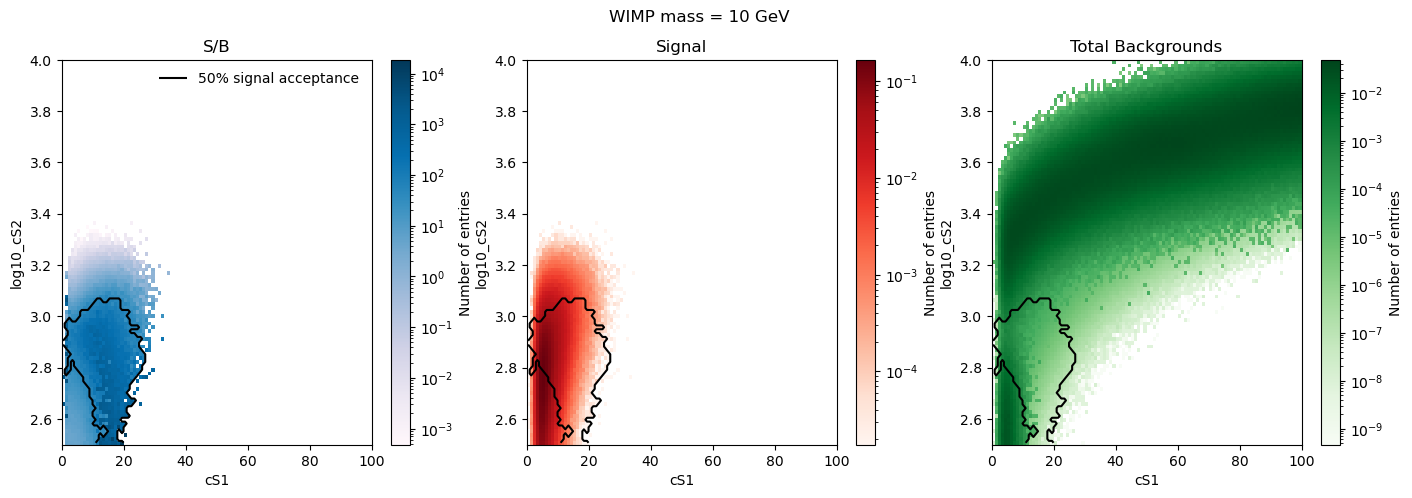

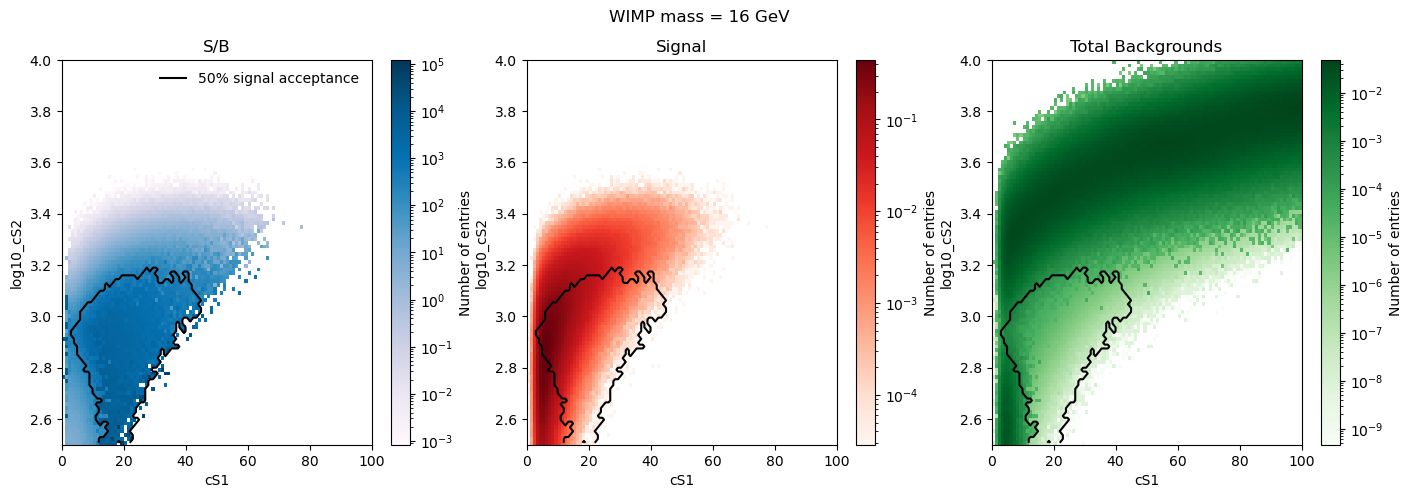

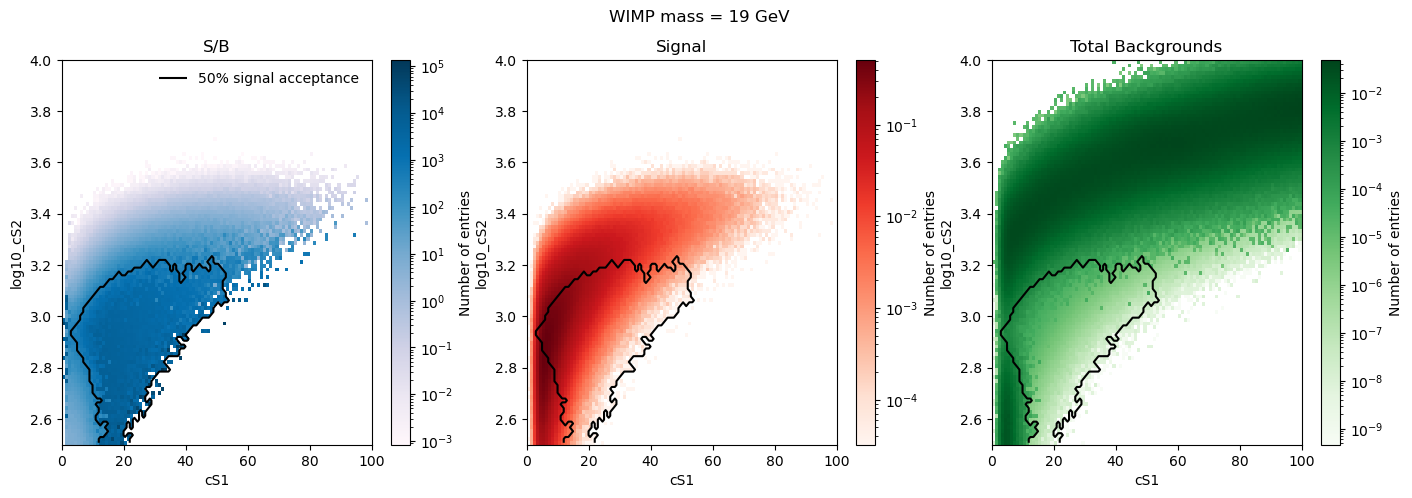

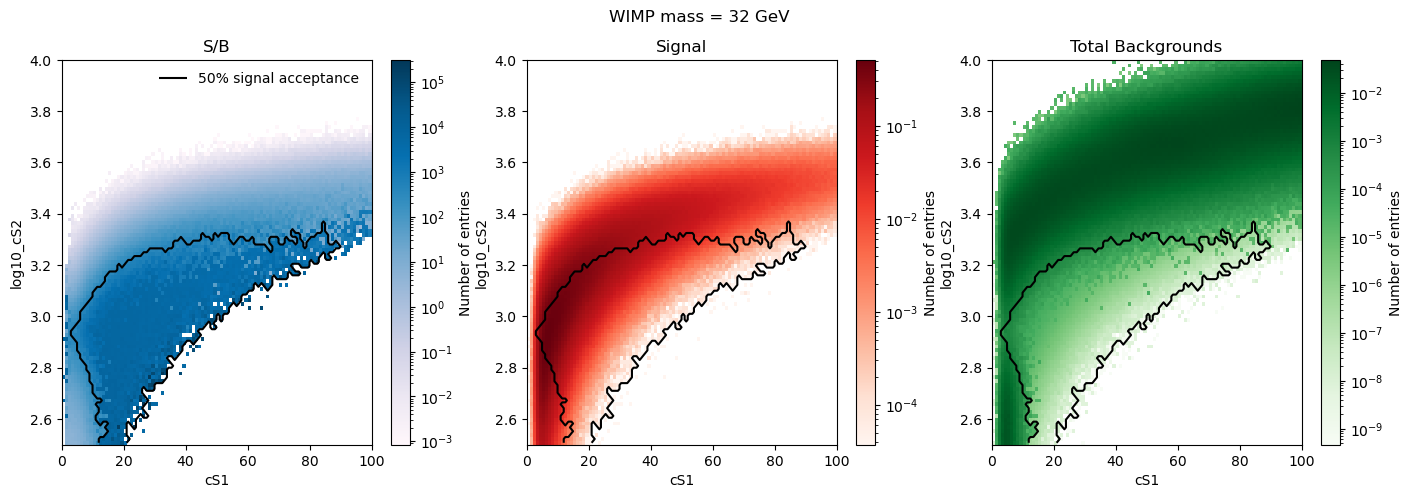

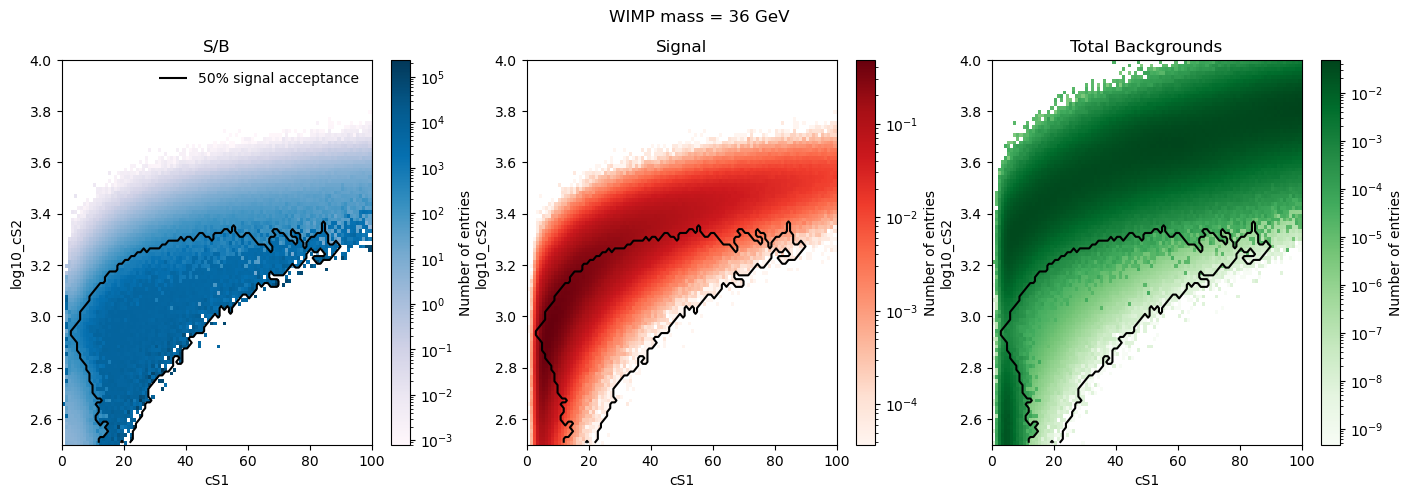

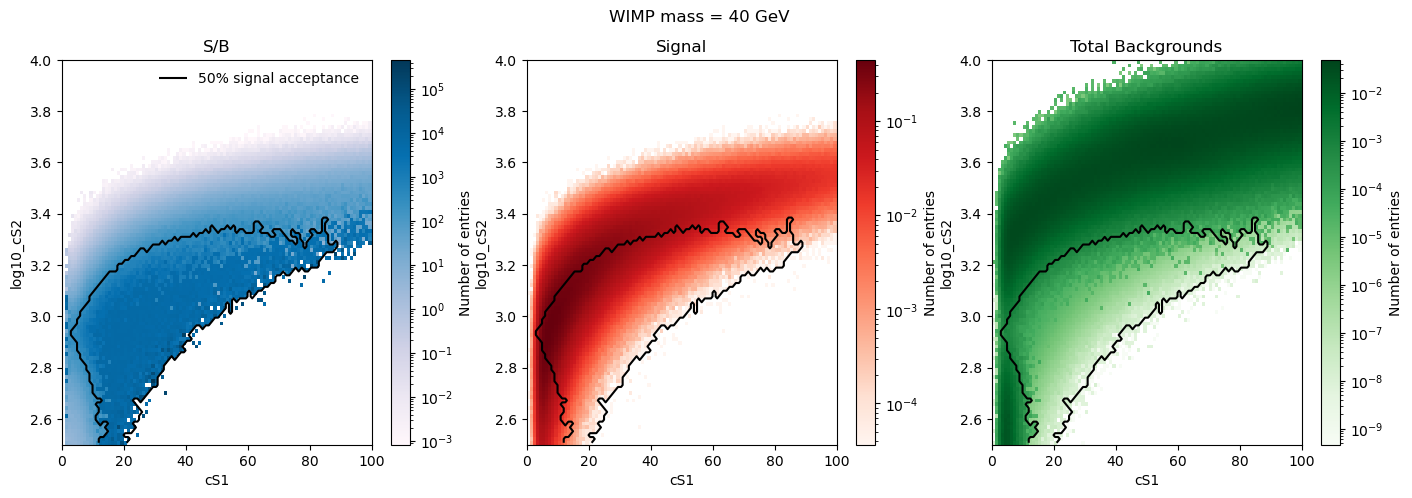

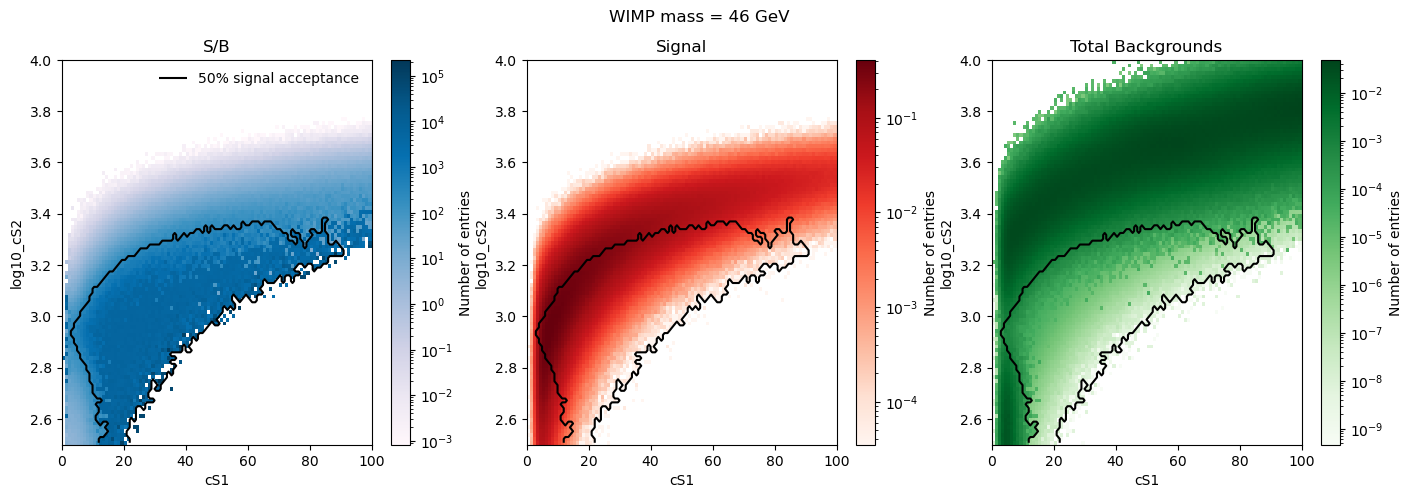

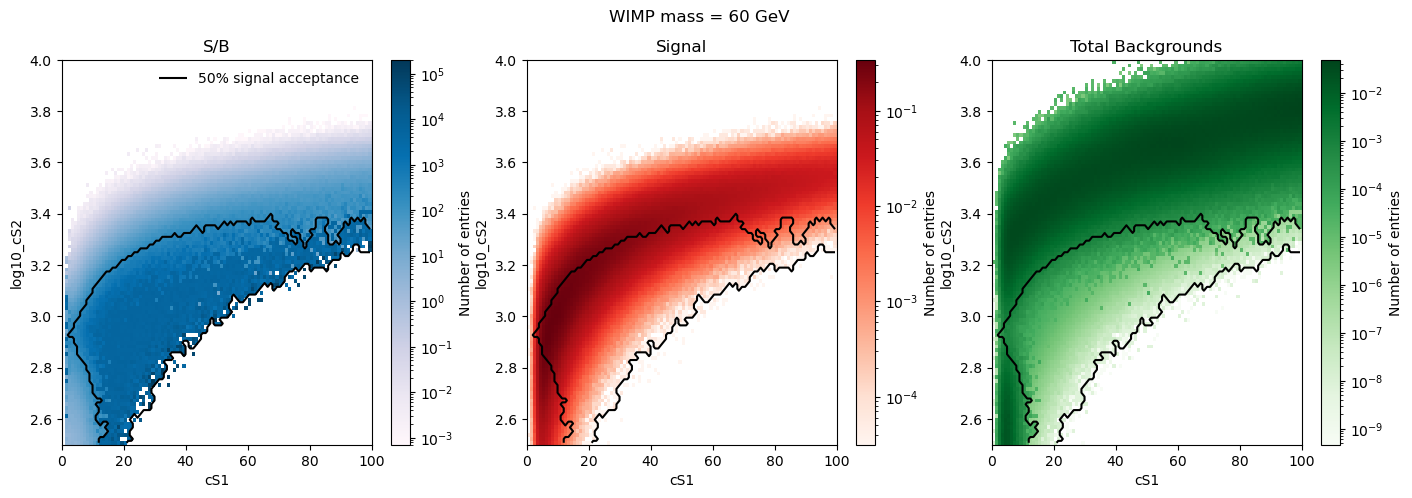

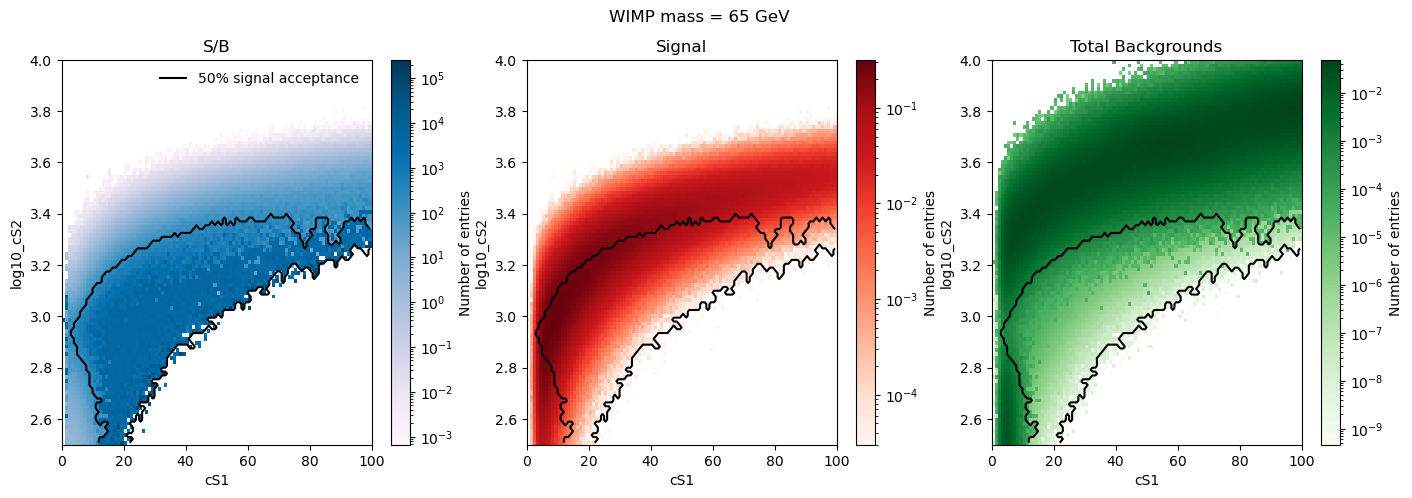

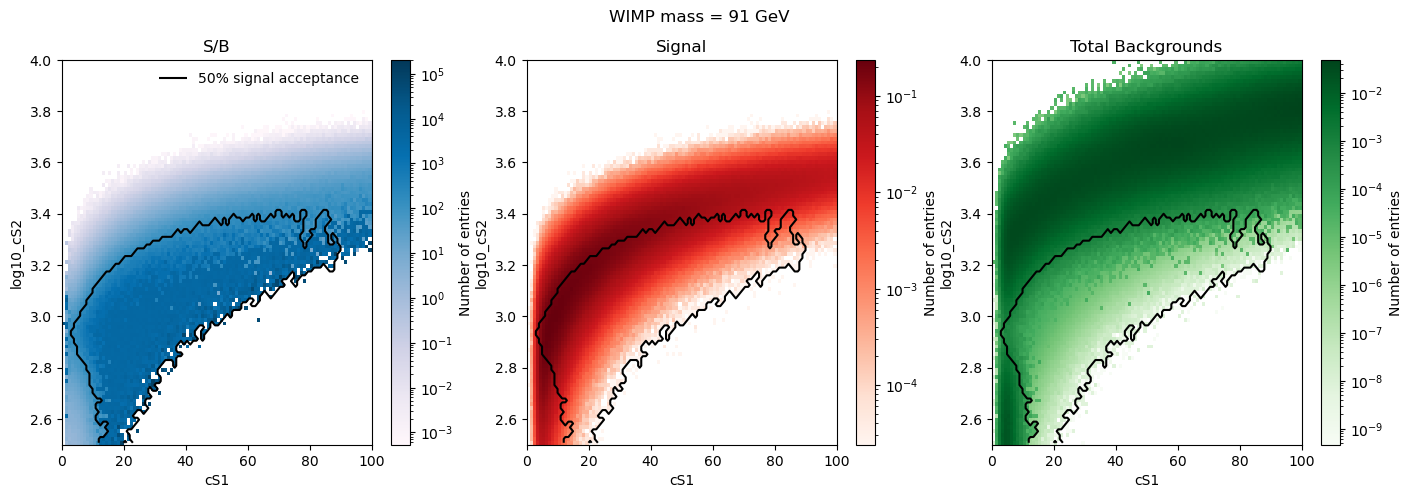

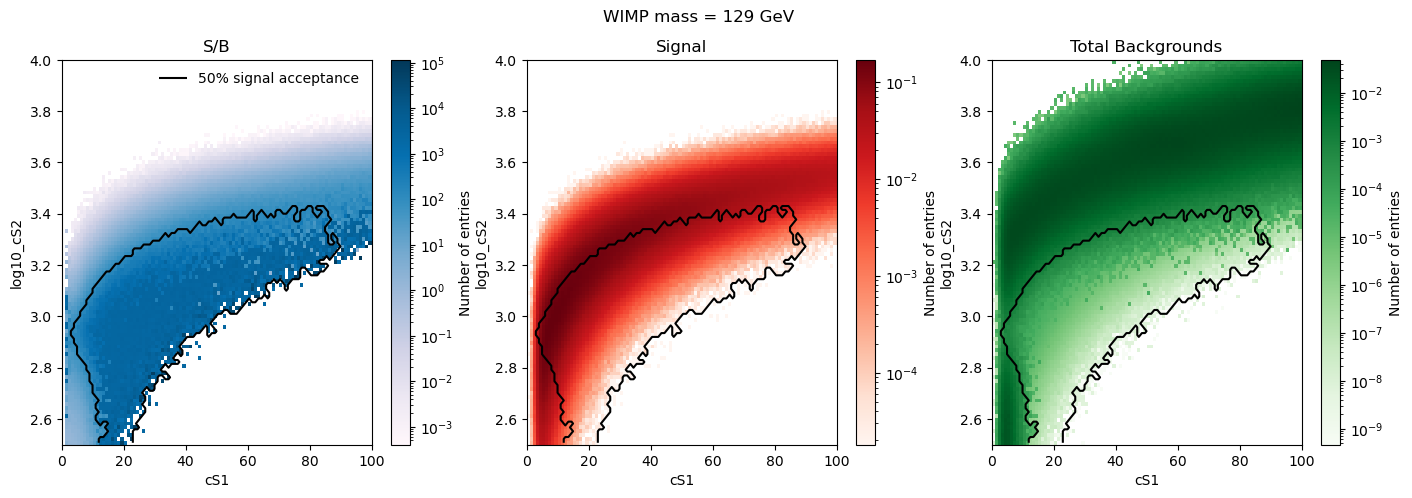

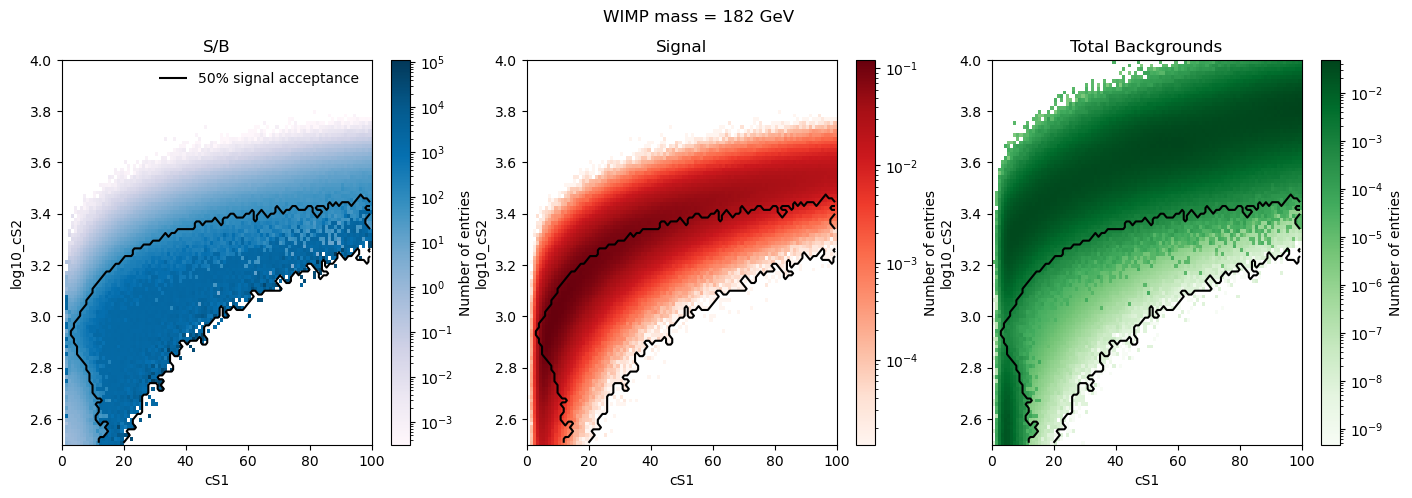

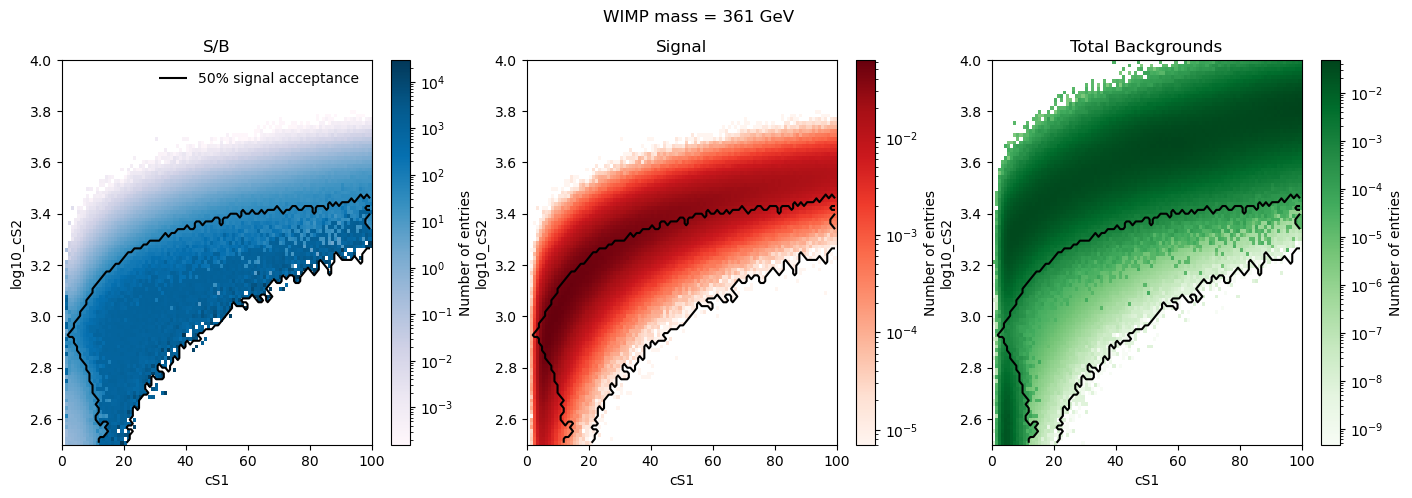

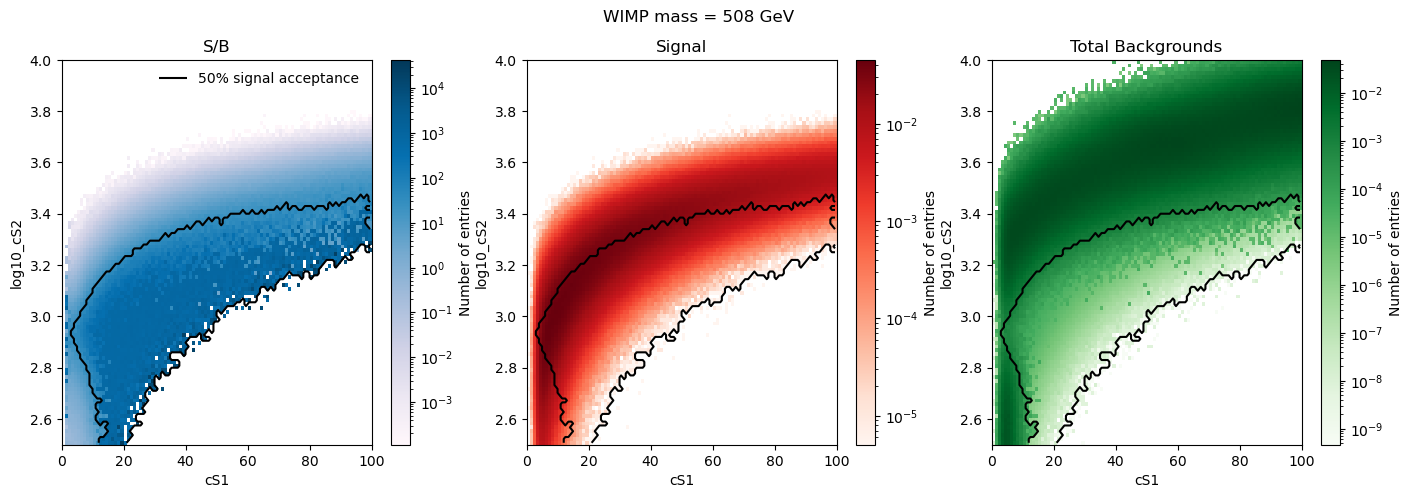

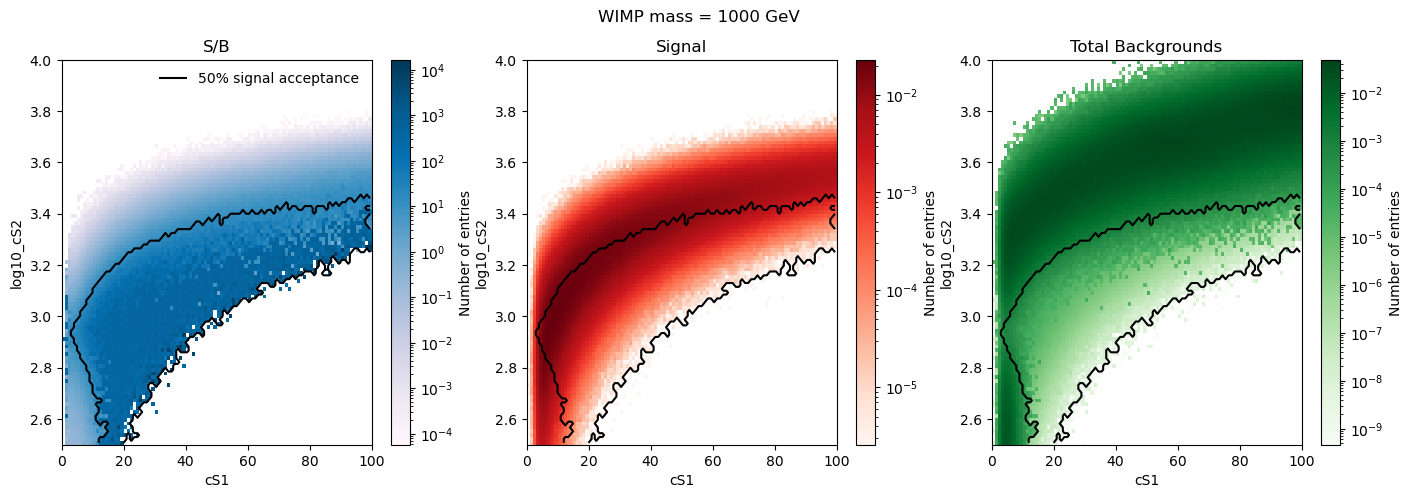

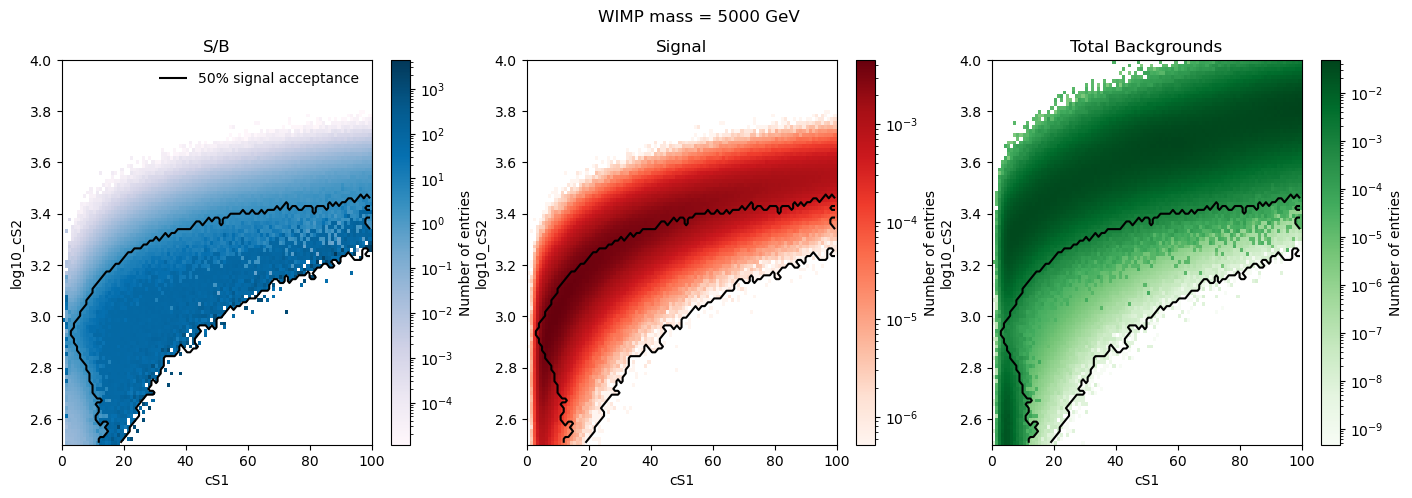

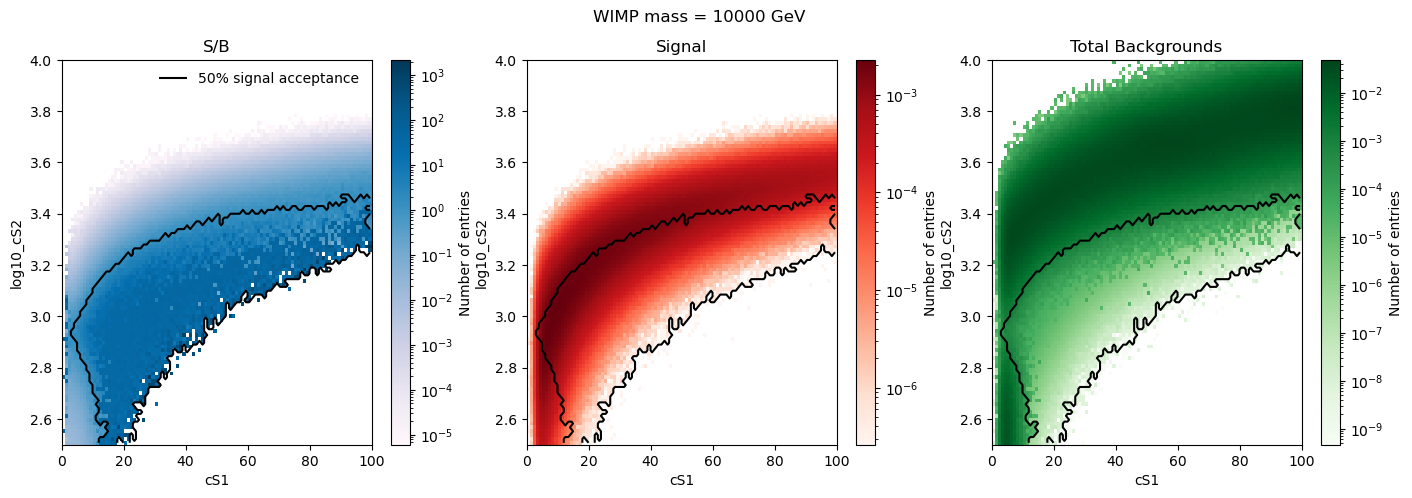

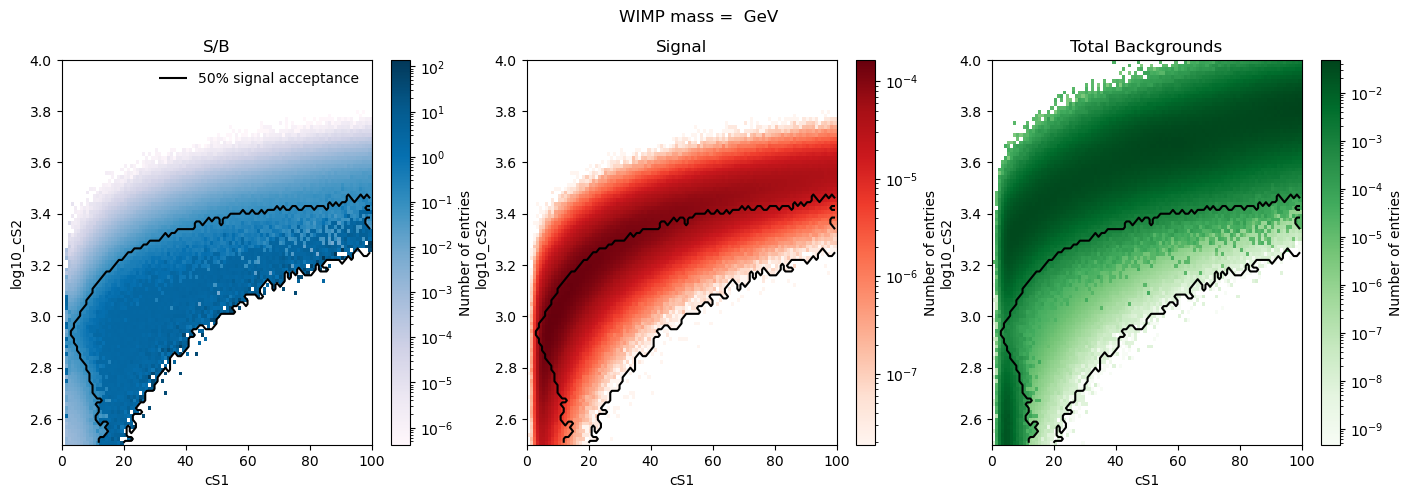

In [7]:
## Plot contour and templates

for key in sorted_keys: 
    # Signal histogram
    if "WIMP" in key:
        # print(key)
        h_sig = hs[key].rebin(r,r,r).sum(axis=2)

        # Get everything for plotting the contour
        mesh_x, mesh_y, llr_mesh, final_mask = get_clean_contour(0.5, h_sig, h_bkgtotal, h_bkgs)
        
        fig, ax = plt.subplots(1,3, figsize=(17,5))

        # Ratio of s/b
        hr = h_sig/h_bkgtotal
        plt.sca(ax[0])
        hr.plot(cmap="PuBu", norm = LogNorm(), label = "S/B")
        contour = ax[0].contour(mesh_x, mesh_y, final_mask.T, levels=[0.5], colors = "black")
        h, _ = contour.legend_elements()
        ax[0].legend([h[0]], ['50% signal acceptance'], frameon = False)
        ax[0].set_title("S/B")
        ax[0].set_xlim(0,100)
        ax[0].set_ylim(2.5,4)

        # Signal
        plt.sca(ax[1])
        ax[1].contour(mesh_x, mesh_y, final_mask.T, levels=[0.5], colors = "black")
        h_sig.plot(cmap="Reds", norm = LogNorm())
        ax[1].set_title("Signal")
        
        # Background
        plt.sca(ax[2])
        ax[2].contour(mesh_x, mesh_y, final_mask.T, levels=[0.5], colors = "black")
        h_bkgtotal.plot(cmap="Greens", norm = LogNorm())
        ax[2].set_title("Total Backgrounds")

        # Save figure
        fig.suptitle(f"WIMP mass = {key.split("WIMP")[1]} GeV")
        # plt.savefig(f"50pSignalContour_{key}.png")


### Save contours to a csv file

In [8]:
contour_paths_dict = {}

for key in sorted_keys: 
    # Signal histogram
    if "WIMP" in key:
        # print(key)
        h_sig = hs[key].rebin(r,r,r).sum(axis=2)

        # Get everything for plotting the contour
        mesh_x, mesh_y, llr_mesh, final_mask = get_clean_contour(0.5, h_sig, h_bkgtotal, h_bkgs)
        

        mesh_x_p, mesh_y_p, mask_p = pad_mask_and_mesh(mesh_x, mesh_y, final_mask)
        contour_paths = extract_contour_paths(mesh_x_p, mesh_y_p, mask_p)
        contour_paths_dict[key] = contour_paths

# Create DataFrame from background data
df = pd.DataFrame.from_dict(contour_paths_dict, orient='index')

# Save to CSV
# df.to_csv('SignalLike_contourpaths.csv')
        

/tmp/ipykernel_261096/725565912.py:8: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in cs.collections:


### Save counts in the contour to csv file

In [9]:
data = {}
signal_inside_contour = {}
data["Signal_total"] = {}
data["Signal"] = {}

r = 1

for key in sorted_keys:
    if "WIMP" in key:
        h_sig = hs[key].rebin(r, r, r).sum(axis=2)
        mesh_x, mesh_y, llr_mesh, final_mask = get_clean_contour(0.5, h_sig, h_bkgtotal, h_bkgs)

        # Save number of signal events inside the contour 
        sigs = h_sig.histogram
        signal_inside_contour[key] = np.sum(sigs[final_mask])
        data["Signal_total"][key] = f"{np.sum(sigs.flatten()):.2g}"
        data["Signal"][key] = f"{signal_inside_contour[key]:.2g}"


        # Now for each background key, get count at index for this signal key
        for bkg_key in h_bkgs:
            h_bkg = h_bkgs[bkg_key].histogram
            # Initialize row if not done
            if bkg_key not in data:
                # data[bkg_key +"_total"] = {}
                data[bkg_key] = {}
            # data[bkg_key +"_total"][key] = f"{sum(h_bkg.flatten()):.2g}"
            data[bkg_key][key] = f"{sum(h_bkg[final_mask]):.2g}"

# Create DataFrame from background data
df = pd.DataFrame.from_dict(data, orient='index')

# Save to CSV
# df.to_csv('background_and_signal_counts_in_contour_2dig.csv')

print("CSV file created: background_and_signal_counts_in_contour.csv")


CSV file created: background_and_signal_counts_in_contour.csv


## Look at one Wimp: 1000 GeV

In [10]:
## rebin factor
r = 1

# Load templates
hs = ii.template_to_multihist("v2.0_PMT_quantum_efficiency_0.37_drift_field_80.00_electron_livetime_10.00_gas_field_6.00.ii.h5")
del hs["CEvNS_other_SURF"] # do not use surf right now


## Create three histograms: Total background, each background, signal
## Sum all histograms over axis 2 and rebin by factor r

# Total background histogram
h_bkgtotal = hs["WIMP"]
h_bkgtotal = h_bkgtotal.similar_blank_histogram()
for k,i in hs.items():
    if "WIMP" not in k:
        print(k, sum(i.sum(axis=2).histogram.flatten()))
        h_bkgtotal.histogram += i.histogram
h_bkgtotal = h_bkgtotal.rebin(r,r,r).sum(axis = 2) # rebin and sum over last axis

# Dictionary with all background histograms
h_bkgs = {}
for key in hs:
    if "WIMP" not in key:
        h_bkgs[key] = hs[key].rebin(r,r,r).sum(axis = 2)


# Signal histogram
h_sig = hs["WIMP1000"].rebin(r,r,r).sum(axis=2)


CEvNS_other_LNGS 0.04640690284789314
CEvNS_solar 0.9378117145660394
Kr85 17.396191524731314
Pb214 3.84949060301515
SolarER 20.63214694500906
Xe124 3.4091853494934155
Xe136 8.260963677673391
neutrons 0.004640690284789374


In [11]:
mesh_x, mesh_y, llr_mesh, final_mask = get_clean_contour(0.5, h_sig, h_bkgtotal, h_bkgs)


/global/homes/r/rhampp/.conda/envs/analysis/lib/python3.13/site-packages/multihist.py:106: RuntimeWarning: divide by zero encountered in divide
  getattr(self.histogram, opname)(other),
/global/homes/r/rhampp/.conda/envs/analysis/lib/python3.13/site-packages/multihist.py:106: RuntimeWarning: invalid value encountered in divide
  getattr(self.histogram, opname)(other),


Text(0.5, 1.0, 'S/B')

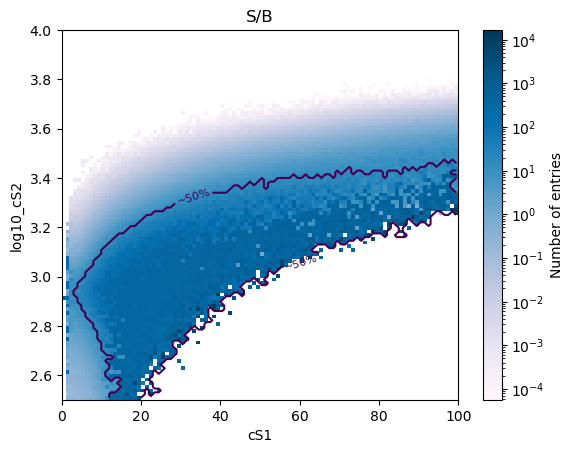

In [12]:
# Plot contour
# Ratio of s/b
hr = h_sig/h_bkgtotal
hr.plot(cmap="PuBu", norm = LogNorm())
contour = plt.contour(mesh_x, mesh_y, final_mask.T, levels=[0.5])
custom_labels = {0.5: "~50%"}

plt.clabel(contour, inline=True, fontsize=8, fmt=custom_labels)

# plt.colorbar()
plt.xlim(0,100)
plt.ylim(2.5,4)
plt.title("S/B")

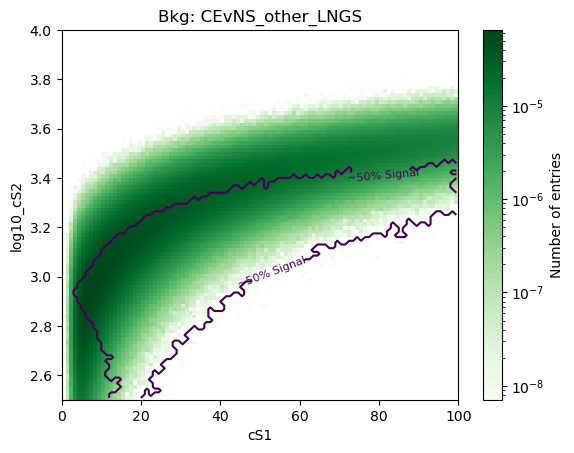

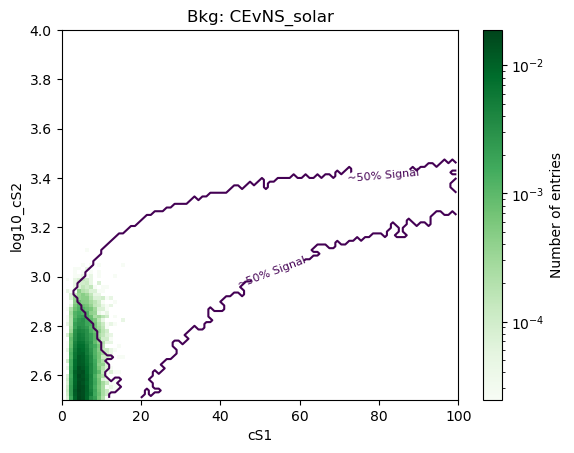

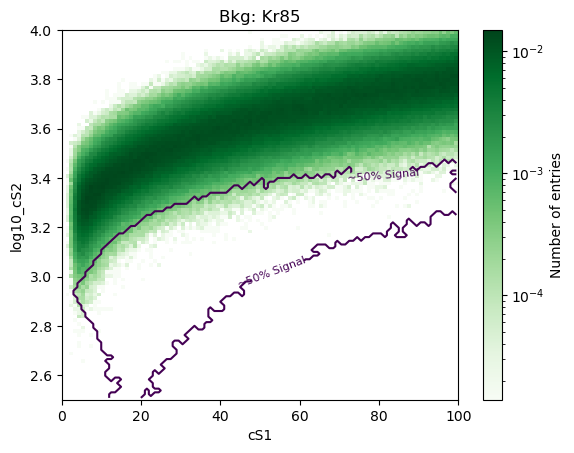

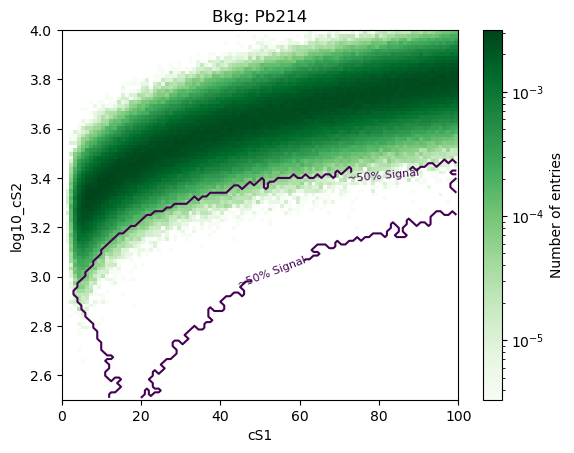

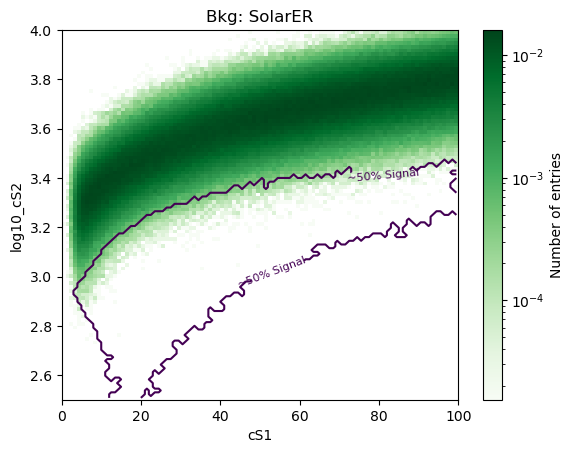

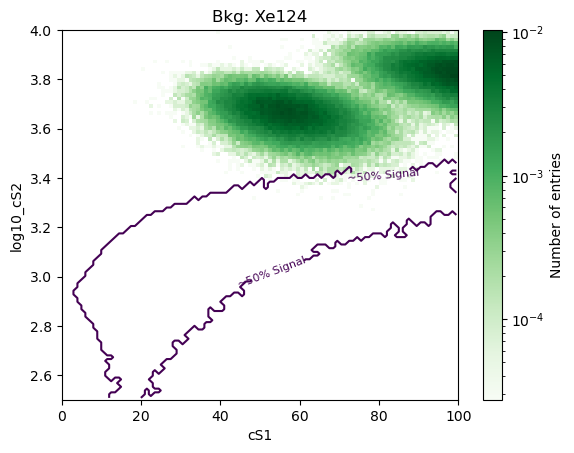

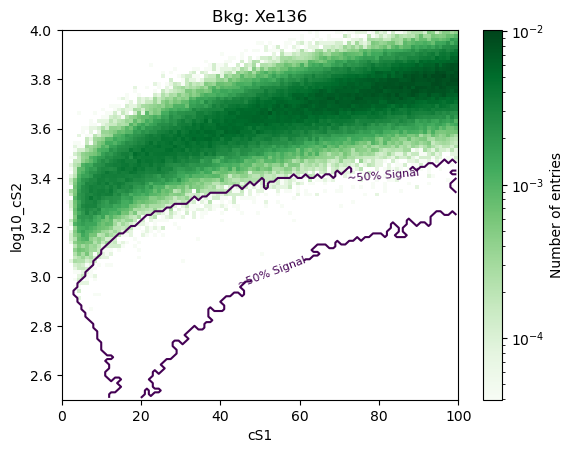

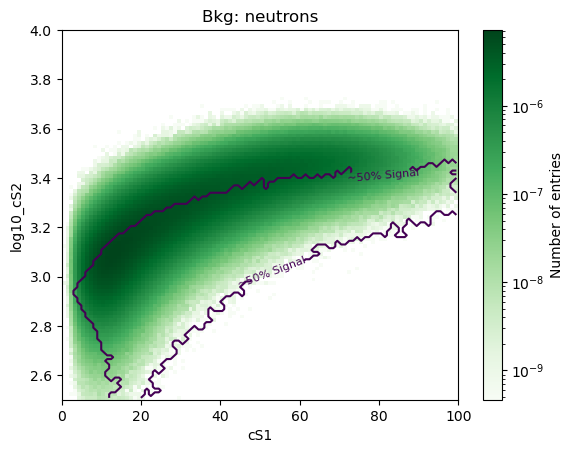

In [13]:
for key in h_bkgs:
    # Ratio of s/b
    plt.figure()
    hr = h_sig/h_bkgs[key]
    h_bkgs[key].plot(cmap="Greens", norm = LogNorm(), label =f"s/b ({key})")

    contour = plt.contour(mesh_x, mesh_y, final_mask.T, levels=[0.5])
    custom_labels = {0.5: "~50% Signal"}

    plt.clabel(contour, inline=True, fontsize=8, fmt=custom_labels)
    plt.xlim(0,100)
    plt.ylim(2.5,4)
    plt.title(f"Bkg: {key}")